 **Using a Pretrained Model**
 
 A common and highly effective approach to deep learning on small image datasets is to use a **pre-trained** network.
A **pre-trained** network is a saved network that was previously trained on a large dataset, typically on a large scale **image-classification** task.

We'll use the **VGG16** Architecture, developed by **Karen Simonyan and Andrew Zisserman** in 2014.

There are two ways to use a pre-trained network **"Feature extraction"** and **"Fine-tunnig"**

**Feature Extraction:-**

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.
    Feature extraction consists of taking the **convolutional base** of the previously trained network, running the new data through it and training a new classifier on the top of the output.
    we can import the previously trained model from the **keras.applications** module. 
   Here is the list of image-classification models that are available as part of **keras.applications**
   
   1. Xception
   2. Inception V3
   3. ResNet 50
   4. VGG 16
   5. VGG 19
   6. Mobile Net
   
   

In [4]:
# Instantiating the VGG 16 Convolutional base

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 141s 2us/step


Three arguments to the constructor:-

**weights:-** specifies the weight checkpoint from which to initialize the model.
**include_top:-** Refers to including (or not) the densely connected classifier on top of the network, we intend to use our own densely connected classifier (with only two classes cats and dogs), we don't need to include it
**input_shape:-** is the shape of image tensors that we shall feed to the network.


In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape **(4,4,512)** that's the feature on top of which we'll stick a densely connected classifier

 At this point, there are two ways we could proceed:-
 
 1. Running the convolutional base over our dataset recording it's output to a Numpy array on disk and then using this data as input to a standalone, denselly connected classifier similar to those we saw in part 1.
     This solution is fast and cheap to run because it only requires running the convolutions base once for every input image , But for the same reason this technique don't allow us to use data augmentation.
     
2. Extending the model we have **(conv_base)** by adding Dense layers on top and running the whole thing end to end on the input data. This will allow us to use data augmentation, because every image go through the convolutional base every time it's seen by the model. But for the same reason, this technique is for more expensive than the first.

Let's walk through the code required to setup the first one:-
Record the output of **"conv_base"** on our data and using these output as inputs to a **New model**.

We'll start by running instance of the previously introduced **"ImageDataGenerator"** to extract image as numpy arrays as well as their labels. we'll  extract features from these images by calling the **"predict"** method of the "**conv_base**" model

In [7]:
# Extracting feature using the pretrained convolutional base

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = r"C:\Users\Raju\Desktop\Project\cats_dogs"
train_dir = os.path.join(base_dir, 'train')              # Training data Path
validation_dir = os.path.join(base_dir, 'validation')    # validation data path
test_dir = os.path.join(base_dir, 'test')                # Testing data path

datagen = ImageDataGenerator(rescale=1./255)            # image data generator

In [11]:
batch_size = 20


def extract_features(directory, sample_count):

    # creating a blank array of the shape (sample,4,4,512)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    # Creating a blank array of the shape of sample size
    labels = np.zeros(shape=(sample_count))

    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch

        i += 1
        if i*batch_size >= sample_count:
            break

    return features, labels

In [12]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
train_features.shape

(2000, 4, 4, 512)

The extracted feature are currently of the shape (samples,4,4,512). we will feed them to a densely connected classifier, so first we must flatten them to (samples,8192)


In [14]:
train_features=np.reshape(train_features,(2000, 4*4*512))
validation_features=np.reshape(validation_features,(1000, 4*4*512))
test_features=np.reshape(test_features,(1000,4*4*512))

At this point, we can define our densely connected classifier (note the use of Dropout for regularization) and train it on the data and labels that we just recorded

In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model=models.Sequential()

model.add(layers.Dense(256, activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

hist=model.fit(train_features,train_labels, batch_size=20,
              epochs=30,
              validation_data=(validation_features,validation_labels))

Epoch 1/30
100/100 [==============================] - 7s 72ms/step - loss: 0.5939 - acc: 0.6810 - val_loss: 0.4209 - val_acc: 0.8440
Epoch 2/30
100/100 [==============================] - 7s 66ms/step - loss: 0.4217 - acc: 0.8015 - val_loss: 0.3667 - val_acc: 0.8430
Epoch 3/30
100/100 [==============================] - 6s 60ms/step - loss: 0.3457 - acc: 0.8435 - val_loss: 0.3622 - val_acc: 0.8300
Epoch 4/30
100/100 [==============================] - 7s 67ms/step - loss: 0.3179 - acc: 0.8655 - val_loss: 0.2936 - val_acc: 0.8880
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2952 - acc: 0.8775 - val_loss: 0.2797 - val_acc: 0.8950
Epoch 6/30
100/100 [==============================] - 6s 62ms/step - loss: 0.2605 - acc: 0.8960 - val_loss: 0.2715 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 6s 60ms/step - loss: 0.2456 - acc: 0.8960 - val_loss: 0.2592 - val_acc: 0.9010
Epoch 8/30
100/100 [==============================] - 6s 64ms/step - 

In [20]:
model.save('cats_and_dogs_small_3.h5')

In [17]:
# let's plot the loss and accuracy score graph

hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

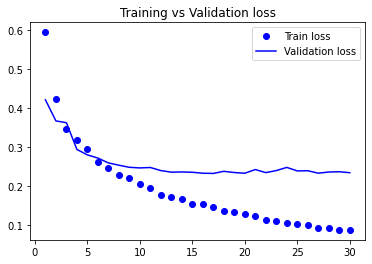

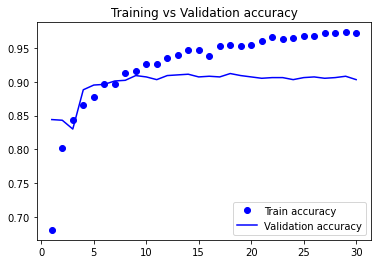

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

train_acc=hist.history['acc']
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
val_acc=hist.history['val_acc']

epochs=range(1,len(train_acc)+1)

plt.plot(epochs,train_loss,'bo',label='Train loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training vs Validation loss')
plt.legend()

plt.figure()

plt.plot(epochs,train_acc,'bo', label='Train accuracy')
plt.plot(epochs, val_acc,'b',label='Validation accuracy')
plt.title('Training vs Validation accuracy')
plt.legend()
plt.show()

We have achieved 90% accuracy better than previous accuracy

**FEATURE EXTRACTION WITH DATA AUGMENTATION**

Now let's review the Second technique:
    Extending the **"conv_base"** model and running it end to end on the inputs.
    
     Note:- you should only attempt it if you have access to a GPU

In [21]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Before we compile and train the model, it's very important to **freeze** the **convolutional base** freezing a layer or set of layers means preventing their weights from being updated during training

In [23]:
print('Before freezing the convolutional base number of trainable weights :-',len(model.trainable_weights))

conv_base.trainable=False

print('After freezing the convolutional base number of trainable weights:-', len(model.trainable_weights))

Before freezing the convolutional base number of trainable weights :- 30
After freezing the convolutional base number of trainable weights:- 4


In [25]:
# Training the model end to end with frozen convolutional base

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen=ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(train_dir,
                                                  target_size=(150,150),
                                                  batch_size=20,
                                                  class_mode='binary')

validation_generator=test_datagen.flow_from_directory(validation_dir,
                                 target_size=(150,150),
                                 batch_size=20,
                                 class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
hist=model.fit_generator(train_generator,
                        steps_per_epoch=100,
                        epochs=30,
                        validation_data=validation_dir,
                        validation_steps=50)

In [ ]:
model.save('cats_and_dogs_small_4.h5')

**Fine Tunning:-**

Fine-tunning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers.
This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reuse in order to make them more relevant for the platform at hand.

The steps for fine-tuning a network are as follows:-
1. Add your custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part you added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and part you added.

In [32]:
# freezing all layers up to a specific one

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [35]:
conv_base.trainable=True
set_trainable =False

for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
        
    else:
        layer.trainable=False

In [36]:
# fine-tuning the model,
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

In [ ]:
hist=model.fit_generator()

**Visualization what convnet learn**

It’s often said that deep-learning models are **“black boxes”**: learning representations
that are difficult to extract and present in a human-readable form. Although this is
partially true for certain types of deep-learning models, it’s definitely not true for
convnets. The representations learned by **convnets** are highly amenable to visualization, in large part because they’re **representations of visual concepts**


